# Teste do Spin Flit.

Nas nossas últimas reuniões o Cristian relatou com uma pequena mudança feita no algoritmo implementado na função ``spin_flip``Estaria gerando resultados totalmente diferentes. Neste notebook se demonstra que as duas implementações são equivalente e que a diferença nos resultados se deve à natureza estocástica do processo modelado. Resta a pergunta de quão significativas são estas diferenças e se elas são coerentes com o modelo proposta e o problema físico que se deseja modelar. 

## O modelo originalmente apresentado.

No notebook disponibilizado Cristian são importados uma serie de pacotes __Python__ alguns de forma incorreta e outros desnecessários.

```
1 import numpy.random as rdm
2 import numpy as np
3 import matplotlib.pyplot as plt
4 import math                     # Não precisa
5 import numpy                    # já foi importado na linha 2
6 import scipy.fftpack    
```
As modificações proposta abaixo não muda de forma alguma o resto do notebook. A mudança implica em duas modificações pontuais no código que serão explicitadas no momento opo
rtuno.

In [1]:
import numpy.random as rdm          # random number generators [Ok]
import numpy as np                  # numerical library [Ok]
import matplotlib.pyplot as plt     # plotting library [Ok]
import scipy.fftpack                # fourier transform library [Ok]
import time                         # time measurement library [Ok]

A função a seguir é utilizada para gerar as configurações iniciais. Trata-se de uma função simples que não precisa de otimizações.   

In [2]:
# estado inicial
def inicial(N):
    ''' 
        Gera o estado inicial do sistema. Um array, de tamanho N, preenchidos com valores
        1 ou -1 
    '''
    state = 2*rdm.randint(2,size=N)-1
    return state

A próxima função gera uma distribuição normal. Aqui se faz necessário mudar uma linha de código por conta da mudança nos pacotes importados. 

In [3]:
# campo aleatório gaussiano
def grf(N):
    alpha = 1.0
    delta = 1.0
    flag_normalize = True

    k_idx = np.mgrid[:N] - int( (N + 1)/2 )
    k_idx = scipy.fftpack.fftshift(k_idx)

    amplitude = np.power( k_idx**2 + 1e-10, -alpha/4.0 )
    amplitude[0] = 0

    noise = rdm.normal(size=(N)) \
        + 1j * rdm.normal(size=(N))

    #gfield = numpy.fft.ifft(noise * amplitude).real   #antes
    gfield = np.fft.ifft(noise * amplitude).real   #depois

    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = delta*gfield/np.std(gfield)

    return gfield

Foi feita uma versão otimizada desta função mas, este notebook não trata ainda das implicações destas otimizações no resultado final. Reparem que o nome da função foi modificado apenas para poder comparar no futuro o desempenho das duas versões.

In [4]:
def grfM(N, alpha=1.0, delta=1.0, flag_normalize=True):
    
    '''
    shift the zero frequency component to the center of the spectrum
    numpy.mgrid = <numpy.lib.index_tricks.MGridClass object>
    An instance which returns a dense multi-dimensional “meshgrid”.
    '''
    
    #k_idx = np.mgrid[:N] - int( (N + 1)/2 )    # antes
    k_idx = np.mgrid[:N] - (N + 1)//2           # Gera o mesmo resultado
    k_idx = scipy.fftpack.fftshift(k_idx)

    amplitude = np.power( k_idx**2 + 1e-10, -alpha/4.0 )
    amplitude[0] = 0

    noise = rdm.normal(size=(N)) + 1j * rdm.normal(size=(N)) # complex noise

    gfield = np.fft.ifft(noise * amplitude).real # inverse Fourier transform

    # normalize the field to have zero mean and unit standard deviation
    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = delta*gfield/np.std(gfield)

    return gfield

Veja aqui o teste da primeira modificação proposta

In [5]:
N = 16
k_idx = np.mgrid[:N] - int( (N + 1)/2 )    # antes
print(k_idx)
k_idx = np.mgrid[:N] - (N + 1)//2           # Gera o mesmo resultado
print(k_idx)

[-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
[-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]


A próxima função foi a que teve o maior número de modificações e que gerou a dúvida a respeito da equivalência entre a versão original e a modificada. A seguir a versão original com uma pequena modificação relacionada aos pacotes que foram importados. 

In [6]:
# Spin flip
def spin_flip(beta,config):
    #nb = 0
    for i in range(N):
        nb = 0
        a = rdm.randint(N)
        s = config[a]
        for j in range(N):
            if j != a:
                nb += config[(j)%N]
        cost = 2*s*nb # cost = 2*E (E1 - E0 = 2E)
        if cost < 0:
            s *= -1
        #elif rdm.rand() < math.exp(-cost*beta):    #antes usa a função exp do pacote math
        elif rdm.rand() < np.exp(-cost*beta):       #depois usa a função exp do pacote numpy  
            s *= -1
        config[a] = s
    return config

Aqui tem um ponto sensível na discussão relacionado ao fato de que na linha 3 se define a variável local ``nb``como sendo igual a 0. Na estrutura de repetição que começa na linha 4 se calcula a soma dos _spins_ de cada iteração mas, como a variável ``nb``não é mais inicializada com zero, a valor calculado é um acumulado e não apenas a soma de uma iteração específica. Esta é uma questão que tem que ser avaliada desde o ponto de vista teórico para escolher entre duas opções:

* Manter como está, fazendo de ``nb`` uma variável acumuladora;
* Zerar ``nb``a cada iteração e usando ela para representado o equilíbrio dos _spins_ em um determinado momento;

Vamos começar mantendo a implementação original.

## A otimização proposta

Aqui temos a otimização proposta e uma breve explicação das otimizações introduzidas.

In [7]:
# Spin flip
def spin_flipM(N, beta, config): # N é o tamanho do array, beta é a temperatura e config é o array de spins
    #nb = 0
    rindex = rdm.randint(N, size=N) #Gera todos os índices aleatórios de uma vez
    #for i in range(N):
    for a in rindex:   # Percorre o array de índices aleatórios
        #a = rdm.randint(N)
        s = config[a]
        #for j in range(N):
        #    if j != a:
        #        nb += config[(j)%N]
        #nb += config[:a].sum() + config[(a+1):].sum()
        nb = config[:a].sum() + config[(a+1):].sum()
        cost = 2*s*nb # cost = 2*E (E1 - E0 = 2E)
        if cost < 0:
            s *= -1
        elif rdm.rand() < np.exp(-cost*beta):
            s *= -1
        config[a] = s
    return config

A primeira modificação está no cabeçalho da função onde agora inserimos também o tamanho do array. No exemplo original funcionou por obra e graça do santo deus dos homens de pouca fê (;-). Veja que função modifica o array e depois retorna o array modificado (ou não) no final (``return``). Como a variável ``config``é oum objeto mutável o ``return``no final é desnecessário, mas não está errado. Desta forma pode deixar como está.

A primeira modificação está na geração do array de índices aleatórios. No lugar de gerar um índice aleatório a cada iteração, gera-se uma array de ``N`` índices aleatórios de uma vez, o que deve melhorar o desempenho. Desta forma se pode fazer uma estrutura de repetição, utilizando o ``for``, que percorra o novo array de índices e não maia uma que utilize um iterador de inteiros na variável ``i``, que não é utilizada para mais nada. 

O laço for interno soma todos os _spins_ do estado atual, excluindo aquele cujo índice é igual ao do índice aleatório da iteração atual. O mesmo cálculo pode ser feito utilizando a ``ufunc sum``, que gera um resultado com um custo computacional menor. Veja que o cálculo é totalmente equivalente, como demonstramos a seguir. 

In [8]:
N = 16
config = inicial(N)
print(config)
a = rdm.randint(N)
print(config[a])
sum = 0
for j in range(N):
    if j != a:
        sum += config[(j)%N]
print(sum)
sum = config[:a].sum() + config[(a+1):].sum()
print(sum)

[ 1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1]
-1
-3
-3


O restante do código desta função permanece inalterado. As outras funções do código foram mantidas inalteradas e serão otimizadas mais adiante.

A função que calcula a energia, por exemplo, tem várias formas de ser melhorada.

In [9]:
# Energia
def energy(config,alpha):
    e = 0
    h = grf(N)
    for i in range(N):
        for j in range(i,N):
            if i != j:
                e += -config[i]*config[j]/(abs(i-j)**alpha) - h[i]*config[i]
    return e

In [10]:
# Magnetizacao
def magnetization(config):
    m = np.sum(config)
    return m

In [11]:
# Densidade de defeito
def defeito(config):
    d = 0
    h = grf(N)   # Aqui se pode usar grfM(N) para testar
    for i in range(N):
        if config[i] != h[i]:
            d += 1
    return d

## Testando e comparando os resultados

Abaixo estão os parâmetros da simução, com as funções dependentes da Temperatura (T)

In [12]:
nt     = 100        #  number of temperature points
N      = 2**4       #  size of the lattice, N
alpha = 2.          #  exponent of the long range interaction
eqSteps = 500       #  number of MC sweeps for equilibration
mcSteps = 500       #  number of MC sweeps for calculation

# valores de temperatura
T       = np.linspace(1, 200, nt);


#time    = np.linspace(0, 100, mcSteps)
E,M,C,X,Cr,Rho = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)

Podemos testar o todo para ver visualizar a diferença entre as implementações. Para garantir a reprodutividade das simulações vamos definir a semente do gerador de números aleatórios.

In [13]:
rdm.seed(1234567890)

Com a implementação original:

In [14]:
# Funcoes variando com a temperatura
#config = inicial(N)
print(config)
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = inicial(N)  # Este ponto precisa ser discutido
    iT=1/T[tt]; iT2=iT*iT; # Termos referentes à temperatura => beta = 1/kT, k=1 é a constante de Boltzmann

    for i in range(eqSteps):         # equilibrate
        spin_flip(iT,config)         # Monte Carlo moves

    for i in range(mcSteps):
        spin_flip(iT,config)
        Ene = energy(config,alpha)     # calculate the energy
        Mag = magnetization(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene

        E[tt] = E1*n1
        M[tt] = M1*n1
        C[tt] = (E2*n1 - E1*E1*n2)*iT2
        X[tt] = (M2*n1 - M1*M1*n2)*iT

[ 1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1]


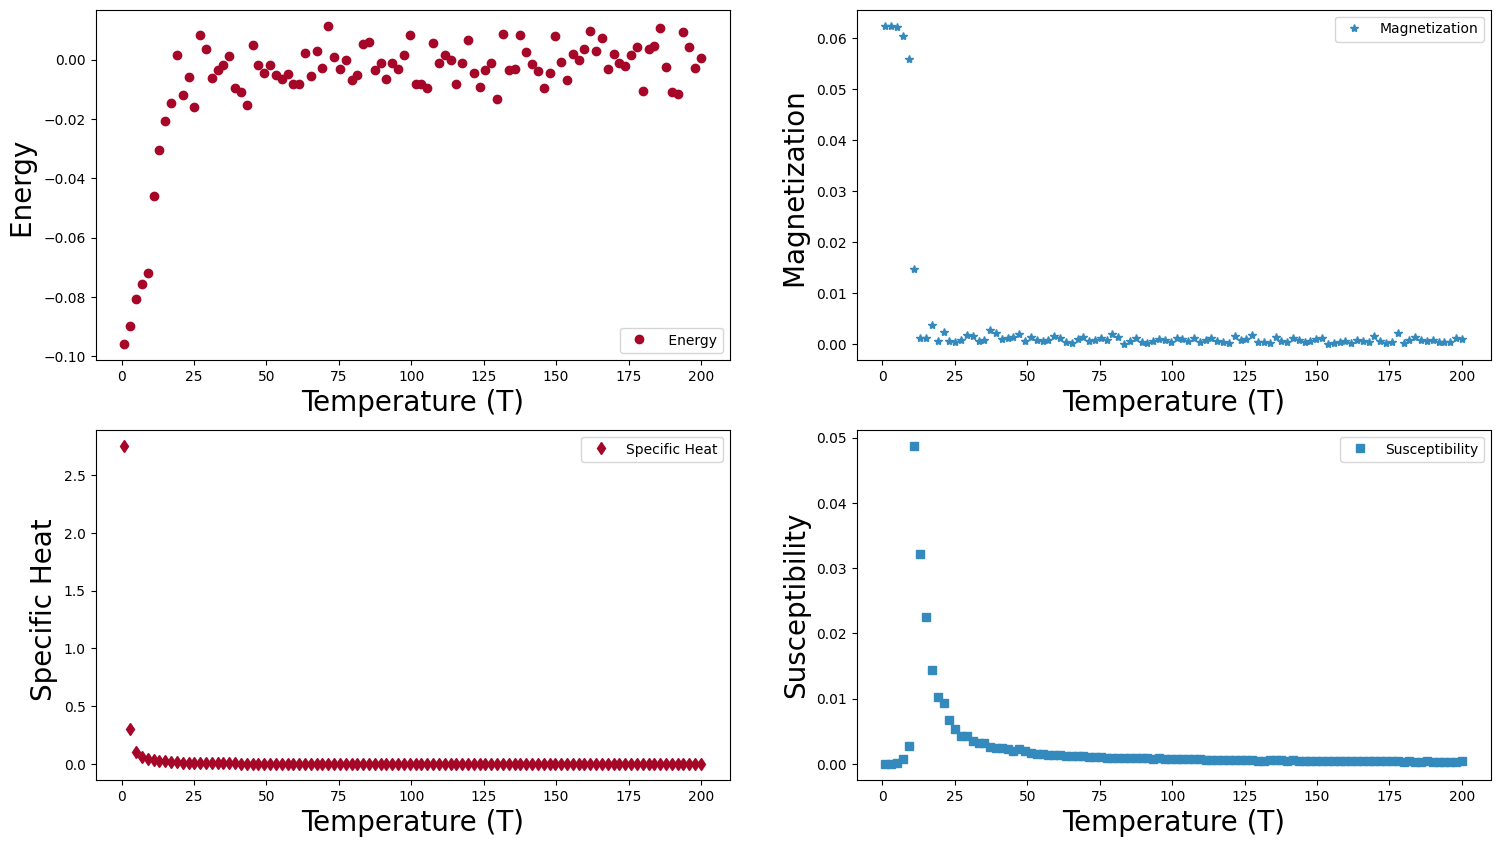

In [15]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T, E, 'o', color="#A60628", label=' Energy');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T, abs(M), '*', color="#348ABD", label='Magnetization');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T, C, 'd', color="#A60628", label='Specific Heat');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T, X, 's', color="#348ABD", label='Susceptibility');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Susceptibility", fontsize=20);
plt.legend(loc='best');

Agora com a função ``spin_flit``modificada

In [16]:
rdm.seed(1234567890)

In [17]:
# Funcoes variando com a temperatura
config = inicial(N)
print(config)
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    # config = inicial(N)  # Este ponto precisa ser discutido
    iT=1/T[tt]; iT2=iT*iT; # Termos referentes à temperatura => beta = 1/kT, k=1 é a constante de Boltzmann

    for i in range(eqSteps):         # equilibrate
        spin_flipM(N, iT,config)         # Mudamos aqui

    for i in range(mcSteps):
        spin_flipM(N, iT,config)     # Mudamos aqui 
        Ene = energy(config,alpha)     # calculate the energy
        Mag = magnetization(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene

        E[tt] = E1*n1
        M[tt] = M1*n1
        C[tt] = (E2*n1 - E1*E1*n2)*iT2
        X[tt] = (M2*n1 - M1*M1*n2)*iT

[-1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 -1]


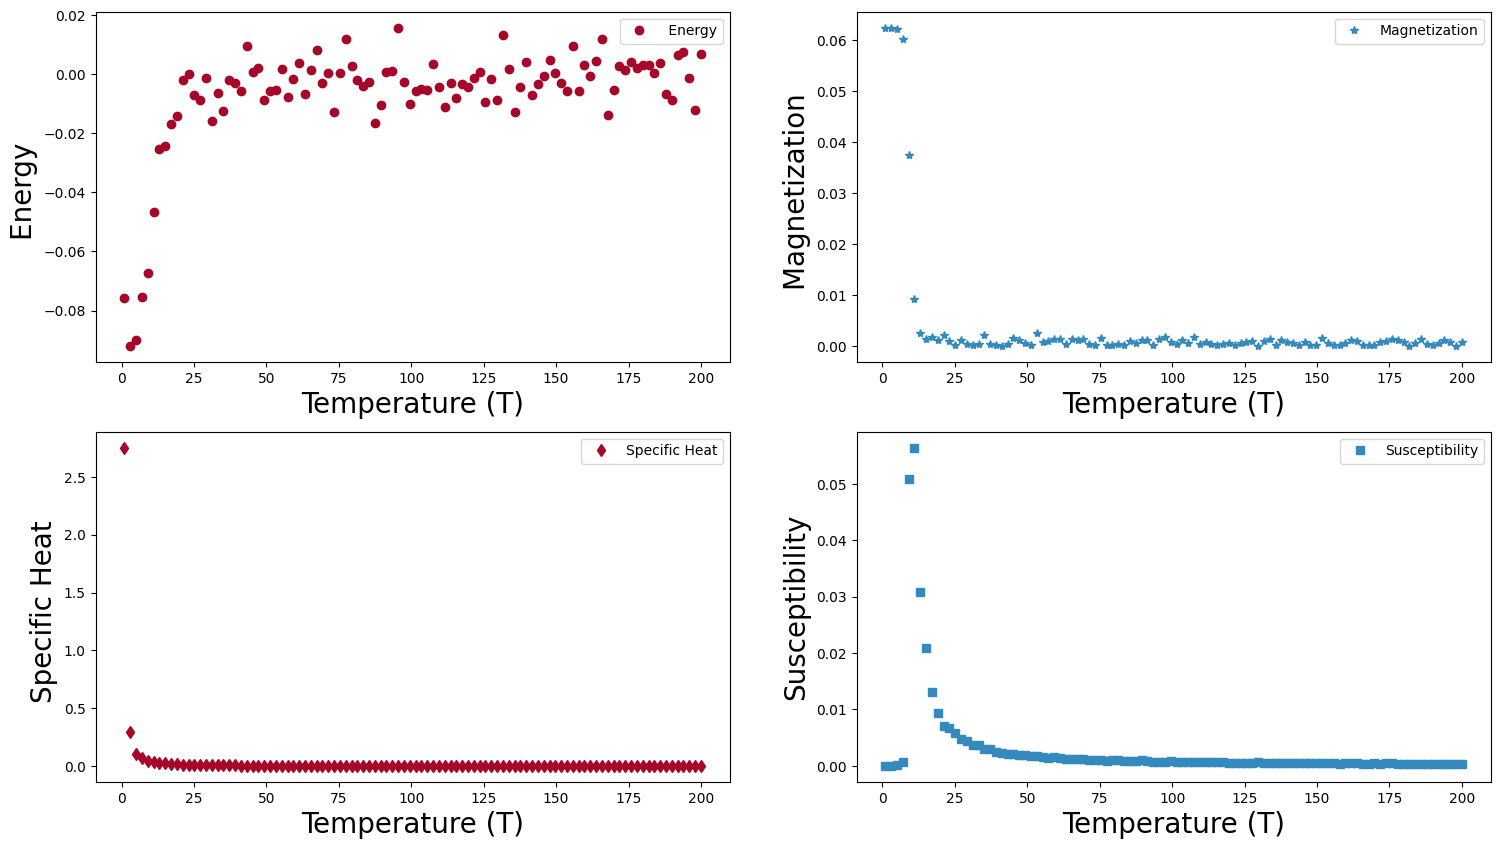

In [18]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T, E, 'o', color="#A60628", label=' Energy');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T, abs(M), '*', color="#348ABD", label='Magnetization');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T, C, 'd', color="#A60628", label='Specific Heat');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T, X, 's', color="#348ABD", label='Susceptibility');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Susceptibility", fontsize=20);
plt.legend(loc='best');

Se comparar as duas figuras pode-se constatar que os resultados não são exatamente iguais mas são semelhantes. Os arrays iniciais são os mesmos, como pode se confirmar comparando os prints incluídos após a sua geração, devido à semente ser redefinida antes de começar o teste das funções modificadas. Mas então por que o resultado final é diferente? 

Ainda que as duas execuções iniciem com o gerador do números aleatórios partindo da mesma semente, a sequencia de geração de números aleatórios difere de uma implementação para outra, o que vai gerar sequencias de números diferentes. Seria possível verificar este fato com um teste que consiste em armazenar os numeros aleatórios gerados no primeiro algoritmo e utilizando eles no segundo. 

Entretanto o Cristian deve ter observado uma discrepância maior devido a uma mudança singela que foi feita nesta implementação. Na otimização original tinha sido proposta a seguinte modificação:

```nb = config[:a].sum() + config[(a+1):].sum()```

Agora foi feita da seguinte forma. 

```nb += config[:a].sum() + config[(a+1):].sum()```

Agora pode-se trabalhar nas próximas otimizações e na discussão sobre qual destas duas implementações faz mais sentido. A segunda é equivalente ao código original enquanto que a primeira exigiria que, no código original foçe inserido um ``nb = 0`` dentro do laço interno. 

__BORA TRABALHAR__

In [30]:
# Energia
def energyM(N, config,alpha):
    e = 0
    h = grf(N)
    h = h*config
    ji = np.arange(1,N)**alpha
    for i in range(N):
        #for j in range(i+1,N):
        #    e += -config[i]*config[j]/((j-i)**alpha) - h[i]

        e += (-config[i]*config[i+1:]/ji[:N-i-1] - h[i]).sum()
    return e

In [27]:
# Energia
def energy(N, config,alpha):
    e = 0
    h = grf(N)
    for i in range(N):
        for j in range(i,N):
            if i != j:
                e += (-config[i]*config[j]/(abs(i-j)**alpha) - h[i]*config[i])
    return e


In [31]:
config = inicial(N)
rdm.seed(1234567890)
e1 = energyM(N,config,alpha)
rdm.seed(1234567890)
e2 = energy(N, config,alpha)
print(e1, e2)

-69.69622878860702 -69.69622878860703
